In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#seaborn 'colorblind' palette
c1,c3,c2,_,_,_,_ = clrs = mpl.rcParams['axes.color_cycle'] = \
[(0.0, 0.4470588235294118, 0.6980392156862745),
 (0.0, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.4745098039215686, 0.6549019607843137),
 (0.9411764705882353, 0.8941176470588236, 0.25882352941176473),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 array((106,65,47))/255.] #muted brown, not originally part of 'colorblind'

In [3]:
import cosmoslik as K
import pypico
import struct
import mspec as M
import os.path as osp

In [4]:
pico=pypico.load_pico("dat/pico/pico3_tailmonty_v35.dat")

In [5]:
clmax800lowl = K.chains.load_chain("dat/chains/formetaparams/base_cmbonly_plikHM_TT_lowTEB_lmax800").join()
clmax2500lowl = K.chains.load_chain("dat/chains/formetaparams/base_cmbonly_plikHM_TT_lowTEB_fullell").join()

In [6]:
f=open("dat/cmbcls/c_matrix_v9.7CS_13p.dat").read()
n=2451
cmbcl=hstack([zeros(50),loadtxt("dat/cmbcls/cl_cmb_v9.7CS_13p.dat")[:,1]])

cmbcov=zeros((2501,2501))
cmbcov[50:,50:]=array(struct.unpack('d'*(len(f)/8-1),f[4:-4])).reshape((n,n))
for i in arange(cmbcov.shape[0]):
    for j in arange(i):
        cmbcov[j,i]=cmbcov[i,j]
        
icmbcov=zeros(cmbcov.shape)
icmbcov[50:,50:]=inv(cmbcov[50:,50:])

In [7]:
def c2p(c):
    o=ones(c.length())
    c.update({'helium_fraction': c['yheused*'],
             'massive_neutrinos': 3.046*o,
             'ombh2': c['omegabh2'],
             'omch2': c['omegach2'],
             'omnuh2': c['omeganuh2*'],
             'pivot_scalar': 0.05*o,
             're_optical_depth': c['tau'],
             'scalar_amp(1)': exp(c['logA'])*1e-10,
             'scalar_nrun(1)': 0*o,
             'scalar_spectral_index(1)': c['ns'],
             'theta': c['theta']/100})

In [8]:
c2p(clmax800lowl); c2p(clmax2500lowl)

In [9]:
params0=clmax800lowl.best_fit()

In [10]:
outputs=['scalar_TT','lensed_TT']

In [11]:
def getdCl(*pdps):
    params1=params0.copy()
    for p,dp in pdps: params1[p]+=dp
    cl1,cl0 = (pico.get(outputs=outputs,force=True,**ps) for ps in [params1,params0])
    return {k:(cl1[k]-cl0[k])/pdps[0][1] for k in outputs}

In [13]:
dCls = {k:getdCl((k,p0/10000)) for k,p0 in params0.items()}

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide


In [15]:
dCls['omegamh2*'] = dCls['omch2'] #take deriv at constant ombh2
dp=params0['ombh2']/10000; dCls['ombh2'] = getdCl(('ombh2',dp),('omch2',-dp)) #take deriv at constant ommh2
dp=0.001; dCls['re_optical_depth'] = getdCl(('re_optical_depth',dp),('scalar_amp(1)',2*dp*params0['scalar_amp(1)'])) #take deriv at constant As*exp(-2tau)
dCls['clamp*']={k:dCls['scalar_amp(1)'][k]*1e-9 for k in outputs}
dCls['yp']=getdCl(('helium_fraction',0.000001))


for k in dCls: dCls[k]['lensing']=dCls[k]['lensed_TT']-dCls[k]['scalar_TT'] #lensing contribution

In [18]:
import cPickle as pickle
pickle.dump(dCls,open('dat/dCls.dat','w'),protocol=2)

In [19]:
bin=M.get_bin_func('q',q=M.lims_to_q(zip(range(50,6000,100),range(149,6000,100))))

In [20]:
def boxerr(ax,xs,errs,dx=45,color='gray',alpha=0.3,**kwargs):
    for x,err in zip(xs,errs):
        ax.fill_between(lmap([x-dx,x+dx]),[-err]*2,[err]*2,color=color,alpha=alpha,**kwargs)

In [21]:
lmap=vectorize(lambda l, lpiv=100., lstretch=100.: lpiv+lstretch*log(l/lpiv) if l<lpiv else l)
def doticks(ax):
    ax.set_xlim(*lmap([1,2500]))
    ticks=[2,100]+range(500,2501,500)
    ax.set_xticks(lmap(ticks))
    ax.set_xticks(lmap(range(10,100,10)+range(100,2500,100)),minor=True)
    ax.set_xticklabels(ticks)

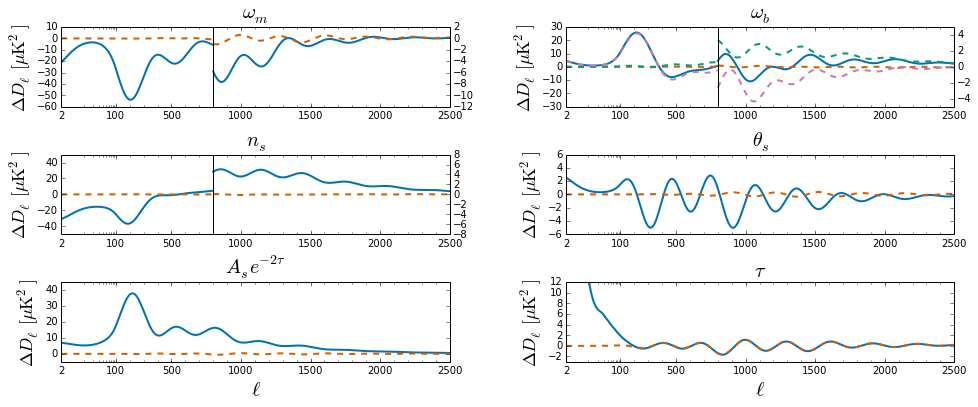

In [56]:
lmin=2
lmax=2500
lsplit=800
f, axarr = subplots(3,2)
f.set_size_inches(16,6)
f.subplots_adjust(wspace=0.3,hspace=0.6)
chainF = clmax2500lowl


#matter
norm=chainF.std('omegamh2*')
for ax,lrange,ylim in [(axarr[0,0],        (lmin,lsplit+1),(-60,10)),
                       (axarr[0,0].twinx(),(lsplit,lmax+1),(-12,2))]:
#     boxerr(ax,bin(arange(2501))[bin(slice(*lrange))],sqrt(diag(bin(cmbcov)))[bin(slice(*lrange))])        
    ax.plot(lmap(arange(*lrange)),dCls['omegamh2*']['lensed_TT'][slice(*lrange)]*norm,'-',c=c1,lw=2)
    ax.plot(lmap(arange(*lrange)),dCls['omegamh2*']['lensing'][slice(*lrange)]*norm,'--',c=c2,lw=2)
#     ax.plot(arange(*lrange),dCl['wmnoL'][slice(*lrange)]*norm,'k-.',lw=2)
    ax.set_ylim(*ylim)
ax.plot([lsplit]*2,ylim,'k')
ax.set_title('$\omega_m$',fontsize=20,y=1.04)


#baryon
norm=chainF.std('omegabh2')
for ax,lrange,ylim in [(axarr[0,1],        (lmin,lsplit+1),(-30,30)),
                       (axarr[0,1].twinx(),(lsplit,lmax+1),(-5,5))]:
#     boxerr(ax,bin(arange(2501))[bin(slice(*lrange))],sqrt(diag(bin(cmbcov)))[bin(slice(*lrange))])
    ax.plot(lmap(arange(*lrange)),dCls['ombh2']['lensed_TT'][slice(*lrange)]*norm,c=c1,lw=2)
    ax.plot(lmap(arange(*lrange)),dCls['ombh2']['lensing'][slice(*lrange)]*norm,'--',c=c2,lw=2)
    
    k='lensed'
    ax.plot(lmap(arange(*lrange)),(dCls['yp']['%s_TT'%k][slice(*lrange)]
                                   *dCls['ombh2']['%s_TT'%k][4000]
                                   /dCls['yp']['%s_TT'%k][4000]*norm),'--',c=c3,lw=2)

    ax.plot(lmap(arange(*lrange)),(dCls['ombh2']['%s_TT'%k][slice(*lrange)]
                                   -dCls['yp']['%s_TT'%k][slice(*lrange)]
                                   *dCls['ombh2']['%s_TT'%k][4000]
                                   /dCls['yp']['%s_TT'%k][4000])*norm,'--',c=clrs[3],lw=2)

    
#     ax.plot(arange(*lrange),dCls['yp'][slice(*lrange)]/dCl['yp'][4100]*dCl['wb'][4100]*norm,'g-.')
#     dCl['wbnoD']=dCl['wb']-dCl['yp']/dCl['yp'][4100]*dCl['wb'][4100]
#     ax.plot(arange(*lrange),dCl['wbnoD'][slice(*lrange)]*norm,'g-.',lw=1)
#     ax.plot(arange(*lrange),dCl['wbL'][slice(*lrange)]*norm,'r--',lw=1)
#     ax.plot(lmin+arange(lmax-lmin+1),dCl['wbL'][lmin:lmax+1]*0.01*params['wb'],'b-.')
    ax.set_ylim(*ylim)
    
ax.plot([lsplit]*2,ylim,'k')
ax.set_title('$\omega_b$',fontsize=20,y=1.04)


#ns
norm=chainF.std('ns')
for ax,lrange,ylim in [(axarr[1,0],        (lmin,lsplit+1),(-50,50)),
                       (axarr[1,0].twinx(),(lsplit,lmax+1),(-8,8))]:
#     boxerr(ax,bin(arange(2501))[bin(slice(*lrange))],sqrt(diag(bin(cmbcov)))[bin(slice(*lrange))])
    ax.plot(lmap(arange(*lrange)),dCls['scalar_spectral_index(1)']['lensed_TT'][slice(*lrange)]*norm,c=c1,lw=2)    
    ax.plot(lmap(arange(*lrange)),dCls['scalar_spectral_index(1)']['lensing'][slice(*lrange)]*norm,'--',c=c2,lw=2)
    ax.set_ylim(*ylim)
    
ax.plot([lsplit]*2,ylim,'k')
ax.set_title('$n_s$',fontsize=20,y=1.04)


#theta
ax=axarr[1,1]
# boxerr(ax,bin(arange(2501)),sqrt(diag(bin(cmbcov))))
ax.plot(lmap(lmin+arange(lmax-lmin+1)),dCls['theta']['lensed_TT'][lmin:lmax+1]*chainF.std('theta'),c=c1,lw=2)
ax.plot(lmap(lmin+arange(lmax-lmin+1)),dCls['theta']['lensing'][lmin:lmax+1]*chainF.std('theta'),'--',c=c2,lw=2)

ax.set_ylim(-6,6)
ax.set_title(r'$\theta_s$',fontsize=20,y=1.04)

#amp
ax=axarr[2,0]
ax.plot(lmap(lmin+arange(lmax-lmin+1)),dCls['clamp*']['lensed_TT'][lmin:lmax+1]*chainF.std('clamp*'),c=c1,lw=2)
ax.plot(lmap(lmin+arange(lmax-lmin+1)),dCls['clamp*']['lensing'][lmin:lmax+1]*chainF.std('clamp*'),'--',c=c2,lw=2)
# boxerr(ax,bin(arange(2501)),sqrt(diag(bin(cmbcov))))
ax.set_title(r'$A_se^{-2\tau}$',fontsize=20,y=1.04)
ax.set_ylim(-5,45)

#tau
ax=axarr[2,1]
# boxerr(ax,bin(arange(2501)),sqrt(diag(bin(cmbcov))))
ax.plot(lmap(lmin+arange(lmax-lmin+1)),dCls['re_optical_depth']['lensed_TT'][lmin:lmax+1]*chainF.std('tau'),c=c1,lw=2)
ax.plot(lmap(lmin+arange(lmax-lmin+1)),dCls['re_optical_depth']['lensing'][lmin:lmax+1]*chainF.std('tau'),'--',c=c2,lw=2)
ax.set_title(r'$\tau$',fontsize=20)
ax.set_ylim(-3,12)


# # axarr[2,1].plot(0.1*(Clfid-ClfidnoL)[:2500],'g-.')
# # axarr[2,0].plot(0.1*(Clfid-ClfidnoL)[:2500],'g-.')


for ax in [axarr[2,0],axarr[2,1]]:
    ax.set_xlabel(r'$\ell$',fontsize=20)

for ax in axarr.ravel():
    ax.set_ylabel(r'${\Delta D_\ell \ [\mu{\rm K}^2]}$',fontsize=18)
    doticks(ax)
    ax.set_xlim(lmap((2,2500)))
    
    
savefig("../paper/plots/dcl.pdf",bbox_inches='tight')

# Metaparams

In [16]:
def getps(ps,sl,c0=None,p0=None):
    if c0 is None: c0=clmax800lowl
    if p0 is None: p0=c0.best_fit()
    Clfid=pico.get(outputs=['lensed_TT'],**p0)['lensed_TT']
    
    dClfid=cmbcl[sl]-Clfid[sl]
    M=array([[dot(dCls[p1][k1][sl],dot(icmbcov[sl,sl],dCls[p2][k2][sl]))
          for p1,k1 in ps]
         for p2,k2 in ps])
    b=array([dot(dCls[p][k][sl],dot(icmbcov[sl,sl],dClfid)) for p,k in ps])
    
    pcov=inv(M)
    pmean=dot(inv(M),b) + [p0[p] for p,_ in ps]
    
    return pmean, pcov

In [17]:
def gauss_combine(mu1,sig1,mu2,sig2):
    sig=inv(inv(sig1)+inv(sig2))
    mu=dot(dot(sig,inv(sig1)),mu1)+dot(dot(sig,inv(sig2)),mu2)
    return mu,sig

In [18]:
ps=['omch2','ombh2','theta','clamp*','scalar_spectral_index(1)','re_optical_depth']
# ps=['omegamh2*','ombh2','theta','clamp*','scalar_spectral_index(1)']

# mu2,sig2=getps([(k,'lensed_TT') for k in ps],slice(800,2500),c0=)
# mu,sig=gauss_combine(mu2,sig2,clmax800lowl.mean(ps),clmax800lowl.cov(ps))

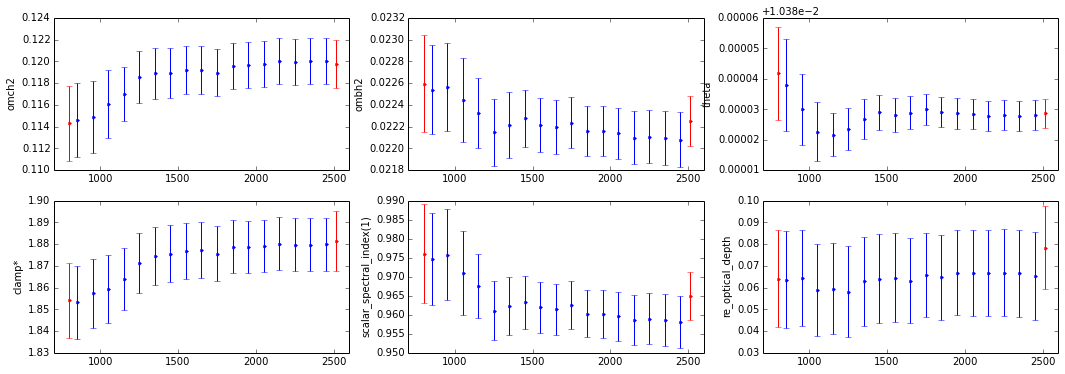

In [19]:
fig,axs=subplots(2,3)
fig.set_size_inches(3*6,6/2*2)
for i,(p,ax) in enumerate(zip(ps,axs.ravel())):
    ax.errorbar(800,clmax800lowl.mean(p),yerr=clmax800lowl.std(p),marker='.',color='r')
    for lmax in range(850,2550,100):
        mu2,sig2=getps([(k,'lensed_TT') for k in ps],slice(800,lmax))
        mu,sig=gauss_combine(mu2,sig2,clmax800lowl.mean(ps),clmax800lowl.cov(ps))
        ax.errorbar(lmax,mu[i],yerr=sqrt(sig[i,i]),marker='.',color='b')
    
    
    ax.errorbar(2515,clmax2500lowl.mean(p),yerr=clmax2500lowl.std(p),marker='.',color='r')
#     ax.errorbar(clmax800lowl_pp2500.mean(p),0,xerr=clmax800lowl_pp2500.std(p),marker='.')    
    ax.set_ylabel(p)
    ax.set_xlim(700,2600)
#     ax.set_yticklabels([])
#     ax.set_ylim(-1,3)